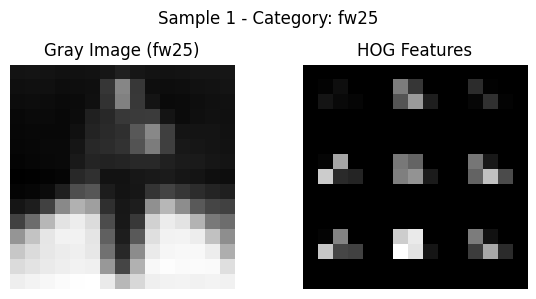

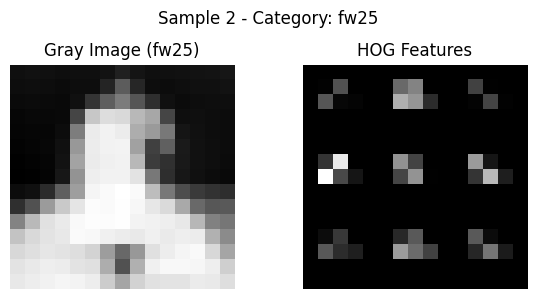

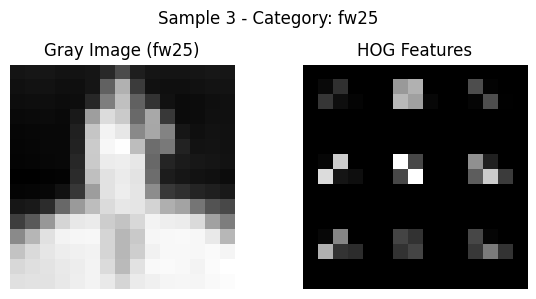

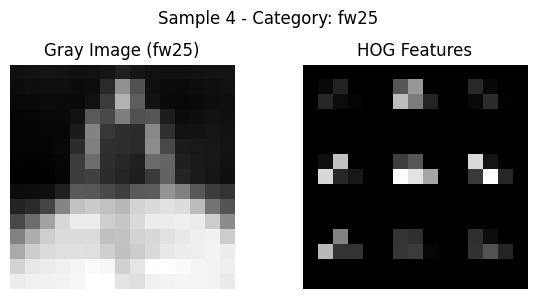

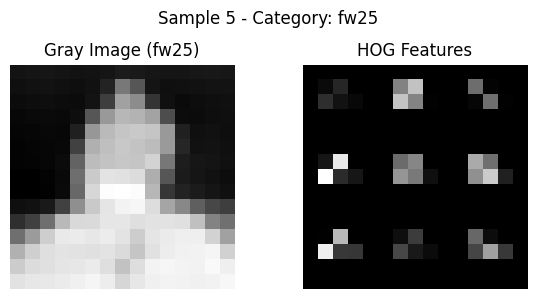

HOG Feature shape: (589, 81)
Labels shape: (589,)
79.66101694915254% of samples were correctly classified using HOG + SVM


In [4]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt

# prepare data
folder = 'images'
input_dir = folder
categories = ['fw25','ss25','r25','fw24','ss24','r24','fw23','ss23','fw22','ss22','r22','fw21','ss21','ss20','r20','fw20','fw19','ss19','r19']

data = []
labels = []

image_extensions = ('.jpg')

# visualization
visualize_limit = 5  # show HOG for first 5 images
visualized = 0

for category_idx, category in enumerate(categories):
    category_path = os.path.join(input_dir, category)
    if not os.path.exists(category_path):
        print(f"Warning: Category folder '{category_path}' not found. Skipping.")
        continue

    for file in os.listdir(category_path):
        if not file.lower().endswith(image_extensions):
            continue

        #hog feature extraction - rezie and greyscale image
        img_path = os.path.join(category_path, file)
        try:
            img = imread(img_path)
            img = resize(img, (15, 15), anti_aliasing=True)
            gray = rgb2gray(img)
            hog_features, hog_image = hog(
                gray,
                pixels_per_cell=(5, 5),
                cells_per_block=(1, 1),
                visualize=True,
                feature_vector=True
            )
            data.append(hog_features)
            labels.append(category_idx)

            # hog visualization
            if visualized < visualize_limit:
                plt.figure(figsize=(6, 3))
                plt.subplot(1, 2, 1)
                plt.imshow(gray, cmap='gray')
                plt.title(f'Gray Image ({category})')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(hog_image, cmap='gray')
                plt.title('HOG Features')
                plt.axis('off')

                plt.suptitle(f'Sample {visualized + 1} - Category: {category}')
                plt.tight_layout()
                plt.show()
                visualized += 1

        except Exception as e:
            print(f"Error reading image {img_path}: {e}")

data = np.asarray(data)
labels = np.asarray(labels)

print("HOG Feature shape:", data.shape)
print("Labels shape:", labels.shape)

# train/test split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

# train classifier with GridSearchCV
classifier = SVC()
parameters = [{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]

grid_search = GridSearchCV(classifier, parameters)
grid_search.fit(x_train, y_train)

# evaluate
best_estimator = grid_search.best_estimator_
y_prediction = best_estimator.predict(x_test)

score = accuracy_score(y_prediction, y_test)
print('{}% of samples were correctly classified using HOG + SVM'.format(str(score * 100)))

# save model
pickle.dump(best_estimator, open('./imgclass_hog', 'wb'))


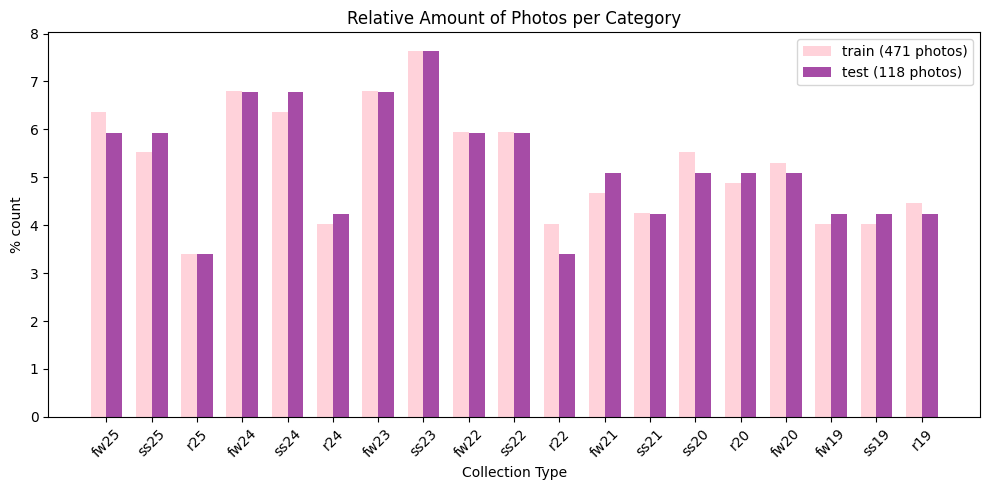

In [5]:
# train/test plot
def plot_bar(y, loc='left', relative=True, color=None):
    width = 0.35
    n = -0.5 if loc == 'left' else 0.5

    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]

    if relative:
        counts = 100 * counts[sorted_index] / len(y)
        ylabel_text = '% count'
    else:
        counts = counts[sorted_index]
        ylabel_text = 'count'

    xtemp = np.arange(len(unique))
    plt.bar(
        xtemp + n * width,
        counts,
        align='center',
        alpha=0.7,
        width=width,
        color=color  # <- now supports color
    )
    plt.xticks(xtemp, [categories[u] for u in unique], rotation=45)
    plt.xlabel('Collection Type')
    plt.ylabel(ylabel_text)

#plot
plt.figure(figsize=(10, 5))
plot_bar(y_train, loc='left', color='pink')
plot_bar(y_test, loc='right', color='purple')
plt.legend([
    f'train ({len(y_train)} photos)', 
    f'test ({len(y_test)} photos)'
])
plt.title('Relative Amount of Photos per Category')
plt.tight_layout()
plt.show()


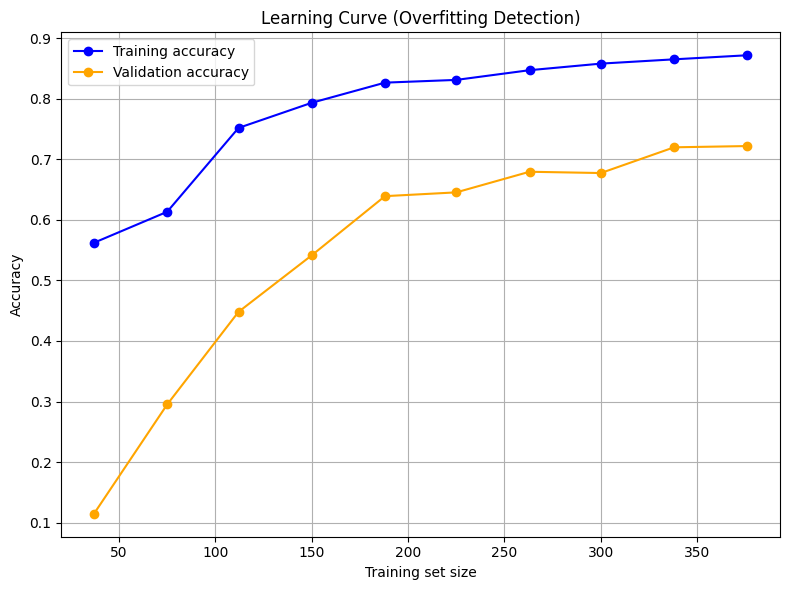

In [6]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_estimator,  # from GridSearchCV
    X=x_train,
    y=y_train,
    cv=5,                      # 5-fold cross-validation
    train_sizes=np.linspace(0.1, 1.0, 10),  # from 10% to 100% of training data
    scoring='accuracy',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training accuracy')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Validation accuracy')

plt.title('Learning Curve (Overfitting Detection)')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


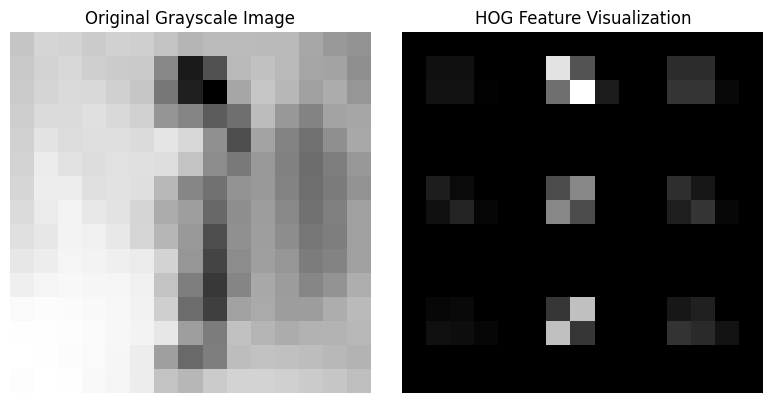

In [8]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Feature Visualization')
plt.axis('off')

plt.tight_layout()
plt.show()
